In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def get_transaction_data(df):

    #Normalize columns names
    df.columns = df.columns.str.lower().str.replace('- ','').str.replace(' ','_').str.replace('?','')
    #Add a date column
    df['transaction_date'] = pd.to_datetime(df[['year','month','day']])
    df['year_month'] = df['year'].astype(str)+'-'+df['month'].astype(str)

    #Remove $ from amount
    df['amount'] = df['amount'].str.replace('$','').astype(float)

    df['amount_bin'] = pd.cut(df['amount'], bins=[0, 50, 100, 500, 1000, float('inf')], labels=[1, 2, 3, 4, 5])


    #Fill missing values
    df['zip'] = df['zip'].fillna(-1).astype(int)
    df['merchant_state'] = df['merchant_state'].fillna('No State')
    df['errors'] = df['errors'].fillna('No Errors')

    #Change fraud flag to numeric
    df['is_fraud'] = np.where(df['is_fraud']=='Yes', 1, 0)

    df['us_state'] = np.where(df['merchant_state'].str.len()==2, 1, 0)

    df['day_of_week'] = df['transaction_date'].dt.dayofweek

    df['is_weekend'] = pd.to_datetime(df['day_of_week']).isin([5, 6]).astype(int)

    df['hour_of_day'] = df['time'].apply(lambda x: int(x.split(':')[0]))

    #Rearrange columns
    df = df[['user', 'card', 'transaction_date', 'year_month','year', 'month', 'day', 'time', 'day_of_week', 'is_weekend', 'hour_of_day', 'amount', 'amount_bin', 'use_chip',
       'merchant_name', 'merchant_city', 'merchant_state', 'zip', 'us_state', 'mcc',
       'errors', 'is_fraud']]


    return df

def get_user_data(df):

    #Normalize Columns
    df.columns = df.columns.str.lower().str.replace('- ','').str.replace(' ','_')

    #Create a user id
    df['user_id'] = df.index

    #Remove person and address columns
    df = df.drop(['person','address'], axis=1)

    #Make dollar amounts floats
    df['per_capita_income_zipcode'] = df['per_capita_income_zipcode'].str.replace('$','').astype(float)
    df['yearly_income_person'] = df['yearly_income_person'].str.replace('$','').astype(float)
    df['total_debt'] = df['total_debt'].str.replace('$','').astype(float)

    #Calculate debt to income and income to per capita income
    df['dti'] = df['total_debt']/df['yearly_income_person']
    df['itpci'] = df['yearly_income_person']/df['per_capita_income_zipcode']

    df['apartment'] = np.where(df['apartment'].isna(), 0, 1)

    #Rearrange columns
    df = df[['user_id', 'current_age', 'gender', 'apartment', 'city', 'state', 'zipcode','per_capita_income_zipcode', 'yearly_income_person', 'total_debt',
        'fico_score', 'num_credit_cards', 'dti','itpci']]

    return df

def get_cards_data(df):

    df.columns = df.columns.str.lower().str.replace('- ','').str.replace(' ','_')
    df['credit_limit'] = df['credit_limit'].str.replace('$','').astype(float)
    
    df['has_chip'] = np.where(df['has_chip']=='YES', 1,0)

    

    df = df[['user', 'card_index', 'card_brand', 
             'card_type', 'has_chip', 'cards_issued', 
             'credit_limit','year_pin_last_changed']]
    
    return df

def get_final_df(transactions,users,cards):

    final_df = pd.merge(left=transactions,right=users,how='inner',left_on='user',right_on='user_id')
    final_df = pd.merge(left=final_df,right=cards,how='inner',left_on=['user','card'],right_on=['user','card_index'])

    final_df['same_state_flag'] = np.where(final_df['merchant_state']==final_df['state'], 1, 0) 

    final_df['user_transaction_count'] = final_df.groupby('user')['is_fraud'].transform('count')

    final_df['merchant_count'] = final_df.groupby('merchant_name')['is_fraud'].transform('count')

    final_df['total_amount'] = final_df.groupby('user')['amount'].transform('sum')
    final_df['average_amount'] = final_df.groupby('user')['amount'].transform('mean')

    final_df['days_since_last_transaction'] = (final_df['transaction_date'].max() - final_df['transaction_date']).dt.days

    final_df['amount_change'] = final_df.groupby('user_id')['amount'].pct_change()
    final_df['amount_change'] = final_df['amount_change'].fillna(0)
    max_val = final_df[final_df['amount_change'] != np.inf]['amount_change'].max()
    final_df['amount_change'] = final_df['amount_change'].replace(np.inf,max_val)


    final_cols = ['user','year', 'month','day_of_week','is_weekend', 'hour_of_day', 'amount', 'amount_bin', 'use_chip', 'merchant_name','merchant_city','merchant_state',
                'zip', 'mcc', 'card_type', 'has_chip','errors','same_state_flag','us_state',
                'user_transaction_count','merchant_count','total_amount','average_amount','days_since_last_transaction',
                'amount_change','is_fraud']
    
    final_df = final_df[final_cols]

    return final_df


In [3]:
cards_df = get_cards_data(pd.read_csv('./data/sd254_cards.csv'))
users_df = get_user_data(pd.read_csv('./data/sd254_users.csv'))
transaction_df = get_transaction_data(pd.read_csv('./data/small_data.csv'))
final_df = get_final_df(transaction_df,users_df,cards_df)

In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295569 entries, 0 to 295568
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   user                         295569 non-null  int64   
 1   year                         295569 non-null  int64   
 2   month                        295569 non-null  int64   
 3   day_of_week                  295569 non-null  int32   
 4   is_weekend                   295569 non-null  int64   
 5   hour_of_day                  295569 non-null  int64   
 6   amount                       295569 non-null  float64 
 7   amount_bin                   284445 non-null  category
 8   use_chip                     295569 non-null  object  
 9   merchant_name                295569 non-null  int64   
 10  merchant_city                295569 non-null  object  
 11  merchant_state               295569 non-null  object  
 12  zip                          295569 non-null

In [5]:
fraud_df = final_df[final_df['is_fraud']==1]

<Axes: xlabel='year'>

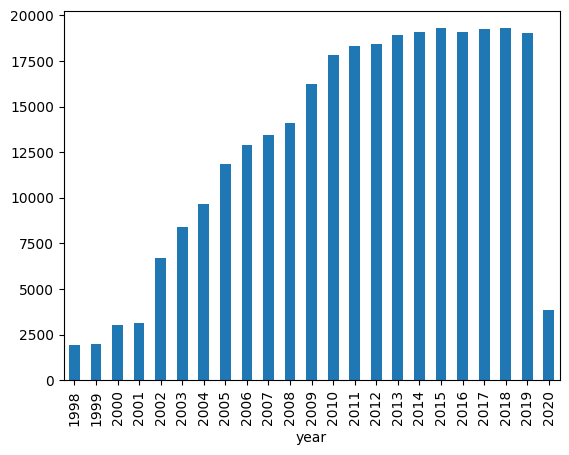

In [6]:
final_df.groupby('year')['amount'].count().plot.bar()

<Axes: xlabel='year'>

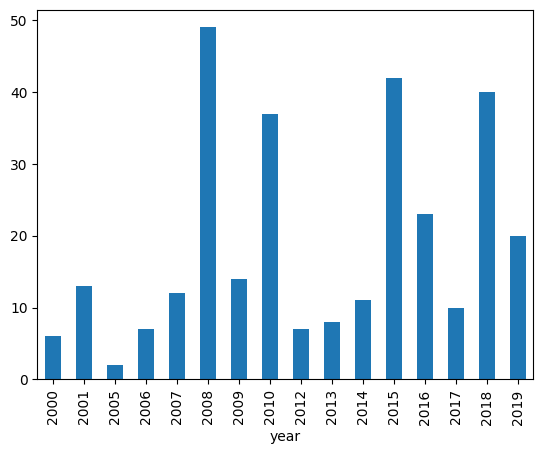

In [7]:
fraud_df.groupby('year')['amount'].count().plot.bar()

<Axes: xlabel='month'>

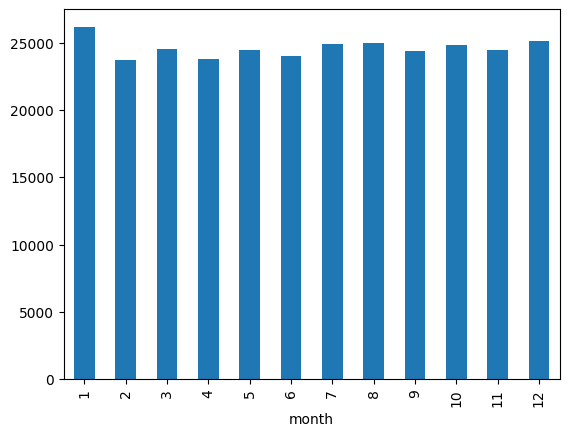

In [8]:
final_df.groupby('month')['is_fraud'].count().plot.bar()

<Axes: xlabel='month'>

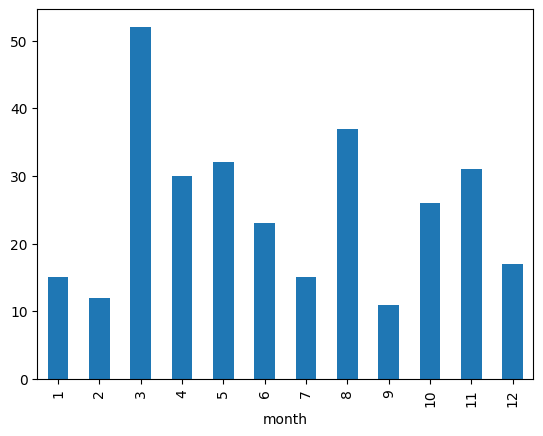

In [9]:
fraud_df.groupby('month')['is_fraud'].count().plot.bar()

<Axes: xlabel='day_of_week'>

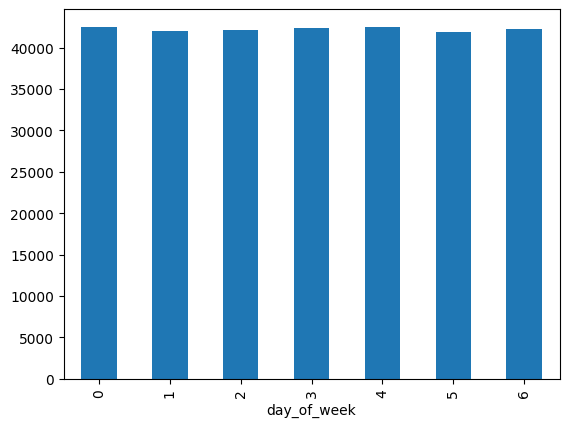

In [10]:
final_df.groupby('day_of_week')['is_fraud'].count().plot.bar()

<Axes: xlabel='day_of_week'>

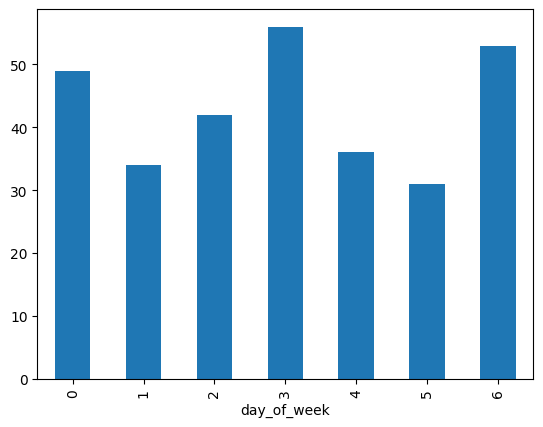

In [11]:
fraud_df.groupby('day_of_week')['is_fraud'].count().plot.bar()

Year, Month, Day of week all have different patterns for fraud than transactions

<Axes: xlabel='hour_of_day'>

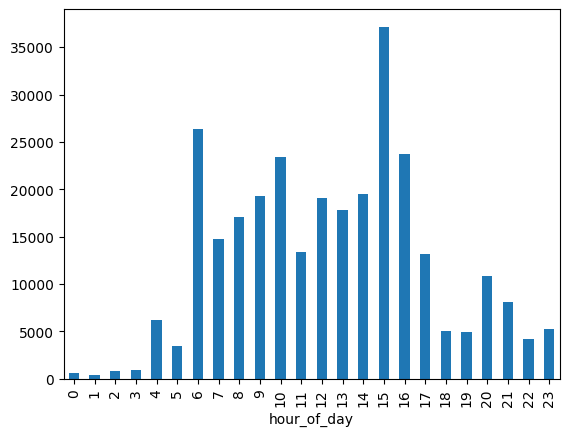

In [12]:
final_df.groupby('hour_of_day')['is_fraud'].count().plot.bar()

<Axes: xlabel='hour_of_day'>

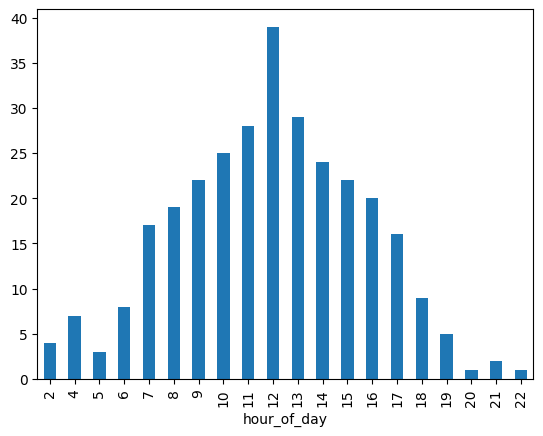

In [13]:
fraud_df.groupby('hour_of_day')['is_fraud'].count().plot.bar()

Different distribution of hour of day will include

In [14]:
final_df.groupby('is_fraud')['amount'].agg(['mean','std'])

,mean,std
is_fraud,,
0,53.206534,96.271654
1,121.887276,263.773827


<Axes: xlabel='use_chip'>

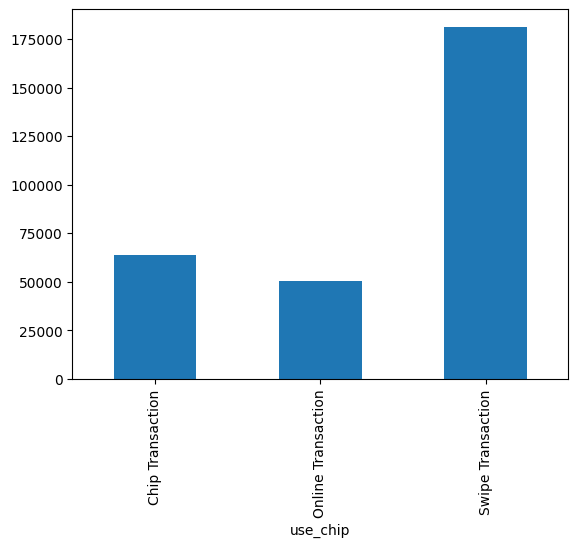

In [15]:
final_df.groupby('use_chip')['is_fraud'].count().plot.bar()

<Axes: xlabel='use_chip'>

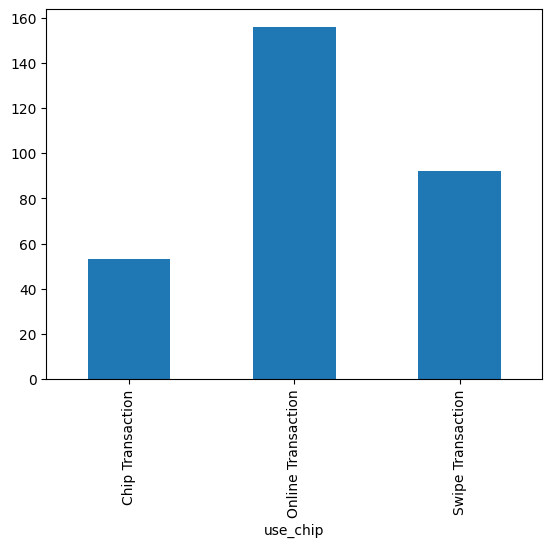

In [16]:
fraud_df.groupby('use_chip')['is_fraud'].count().plot.bar()

Most transactions are swipe, however most fraud is online transactions

In [17]:
final_df.groupby('merchant_name')['is_fraud'].count().sort_values(ascending=False)

merchant_name
-4282466774399734331    24011
-6458444334611773637    16313
 1799189980464955940    10722
 6666504894937430109    10030
 2027553650310142703     9938
                        ...  
 802916410570306327         1
 9177190771931264822        1
 9158018520908212892        1
 9148045740109048593        1
 9128802257715381400        1
Name: is_fraud, Length: 4107, dtype: int64

In [18]:
fraud_df.groupby('merchant_name')['is_fraud'].count().sort_values(ascending=False).head(20)

merchant_name
 1913477460590765860    17
-4282466774399734331    15
-2916542501422915698    12
 9057735476014445185    11
 3189517333335617109    10
 1715299929786123066     7
-3220758452254689706     7
-245178307025547046      6
 4872340518840476610     6
-8566951830324093739     5
-112121233619748226      5
 4241336128694185533     4
 5507353000713503121     4
 483490033258680568      4
-7231389139399574921     4
 2919745757515313025     4
-5162038175624867091     4
 1799189980464955940     3
 6661973303171003879     3
 6051395022895754231     3
Name: is_fraud, dtype: int64

In [19]:
fraud_df.groupby('merchant_city')['is_fraud'].count().sort_values(ascending=False).head(20)

merchant_city
ONLINE            156
Rome               70
Abuja              10
Algiers             9
Mexico City         6
Flagstaff           5
Claremont           3
Upland              3
Spearman            3
Corona              3
Port au Prince      2
Brooklyn            2
Bloomville          1
Anaheim             1
Arp                 1
Bartlesville        1
Bancroft            1
Boise City          1
Harrietta           1
Lake Ann            1
Name: is_fraud, dtype: int64

In [20]:
fraud_df.groupby('merchant_state')['is_fraud'].count().sort_values(ascending=False).head(20)

merchant_state
No State    156
Italy        70
CA           17
Nigeria      10
Algeria       9
TX            8
Mexico        6
AZ            5
OK            5
NY            4
OH            4
MI            2
Haiti         2
CO            1
IN            1
NE            1
Name: is_fraud, dtype: int64

There is clearly leaders for merchants, merchant city, merchant state

In [21]:
fraud_df.groupby('zip')['is_fraud'].count().sort_values(ascending=False).head(20)

zip
-1        253
 79081      3
 86003      3
 91711      3
 92881      3
 11201      2
 91784      2
 86004      2
 11417      1
 11362      1
 44818      1
 44680      1
 47803      1
 44820      1
 73942      1
 73949      1
 74578      1
 44842      1
 49650      1
 68004      1
Name: is_fraud, dtype: int64

In [22]:
fraud_df.groupby('mcc')['is_fraud'].count().sort_values(ascending=False).head(20)

mcc
5311    46
5300    19
5310    18
4829    15
5912    14
5411    13
5211    11
5719    11
5651    11
5732     8
3722     7
4121     7
5932     7
5921     6
3640     5
3509     5
5541     5
4214     5
5712     4
5812     4
Name: is_fraud, dtype: int64

MCC is stacked as well at the top

<Axes: xlabel='card_type'>

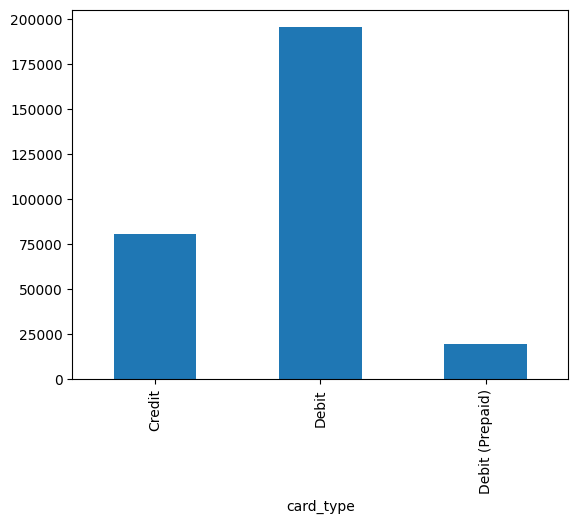

In [23]:
final_df.groupby('card_type')['is_fraud'].count().plot.bar()

<Axes: xlabel='card_type'>

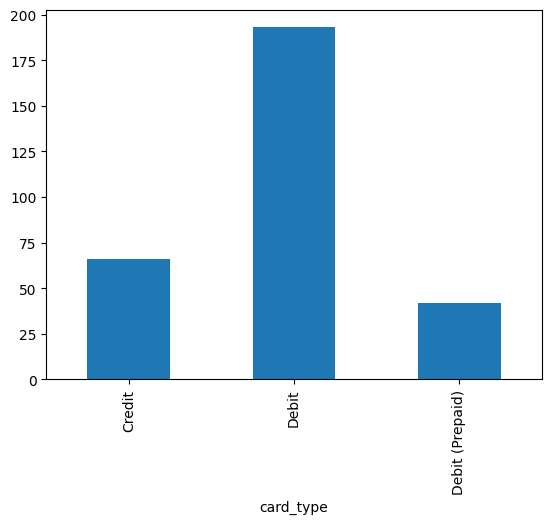

In [24]:
fraud_df.groupby('card_type')['is_fraud'].count().plot.bar()

In [25]:
final_df.groupby('is_fraud')['card_type'].value_counts(normalize=True).reset_index().sort_values(by=['card_type','is_fraud'])

,is_fraud,card_type,proportion
1,0,Credit,0.273169
4,1,Credit,0.219269
0,0,Debit,0.660563
3,1,Debit,0.641196
2,0,Debit (Prepaid),0.066269
5,1,Debit (Prepaid),0.139535


Distribution amongst card type is about the same, will leave out

In [26]:
final_df.groupby('is_fraud')['has_chip'].value_counts().reset_index().sort_values(by=['has_chip','is_fraud'])

,is_fraud,has_chip,count
1,0,0,46585
3,1,0,61
0,0,1,248683
2,1,1,240


In [27]:
final_df.groupby('is_fraud')['has_chip'].value_counts(normalize=True).reset_index().sort_values(by=['has_chip','is_fraud'])

,is_fraud,has_chip,proportion
1,0,0,0.157772
3,1,0,0.202658
0,0,1,0.842228
2,1,1,0.797342


Has chip follows roughly same results for fraud vs non fraud

In [28]:
fraud_df.groupby('errors')['is_fraud'].count().sort_values(ascending=False).head(20)

errors
No Errors               286
Insufficient Balance      6
Bad PIN                   3
Technical Glitch          3
Bad Expiration            2
Bad CVV                   1
Name: is_fraud, dtype: int64

Most fraud occurs without errors

<Axes: xlabel='same_state_flag'>

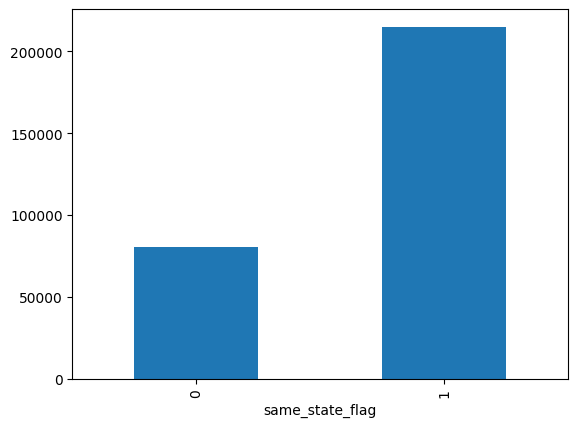

In [29]:
final_df.groupby('same_state_flag')['is_fraud'].count().plot.bar()

<Axes: xlabel='same_state_flag'>

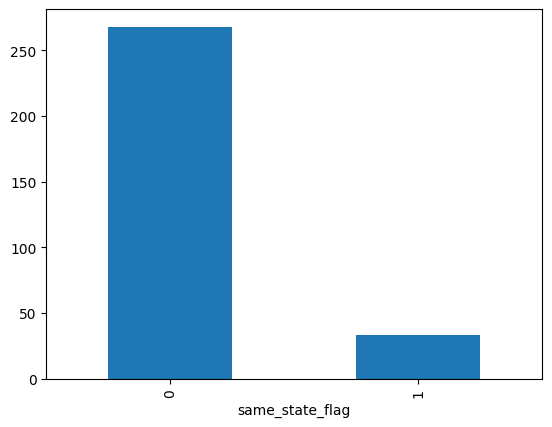

In [30]:
fraud_df.groupby('same_state_flag')['is_fraud'].count().plot.bar()

If the card is used in a different state , there is a much high probability of fraud

<Axes: xlabel='us_state'>

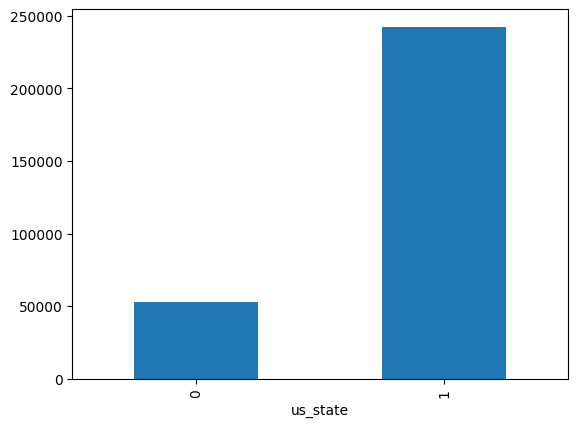

In [31]:
final_df.groupby('us_state')['is_fraud'].count().plot.bar()

<Axes: xlabel='us_state'>

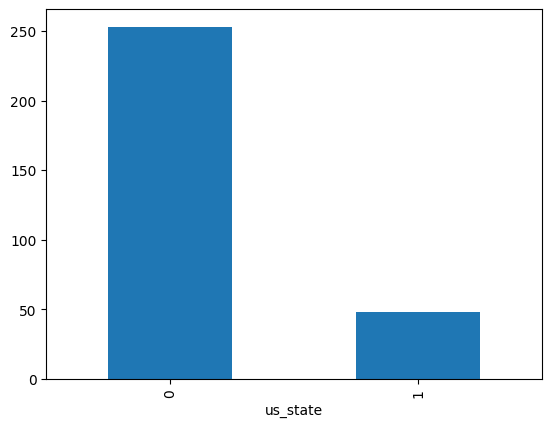

In [32]:
fraud_df.groupby('us_state')['is_fraud'].count().plot.bar()

US state is very similiar to same state flag, we can leave one of these out

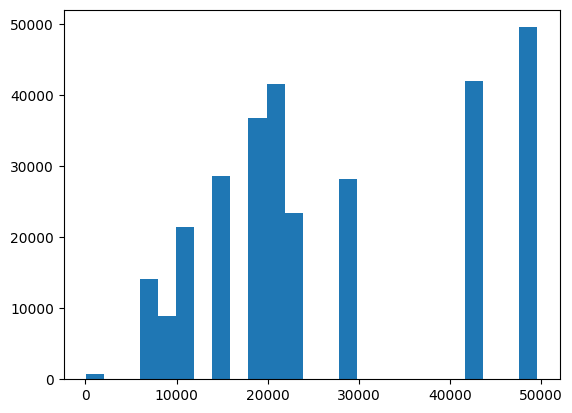

In [33]:
plt.hist(final_df['user_transaction_count'],bins=25)
plt.show()

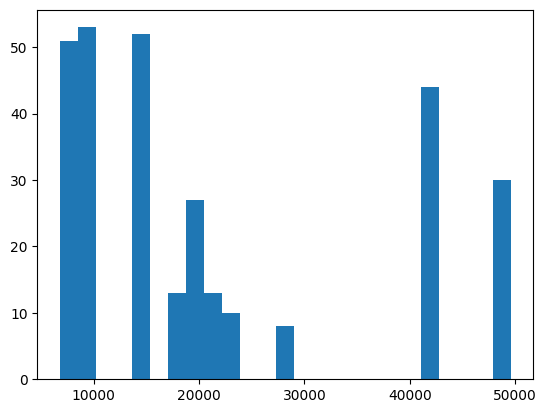

In [34]:
plt.hist(fraud_df['user_transaction_count'],bins=25)
plt.show()

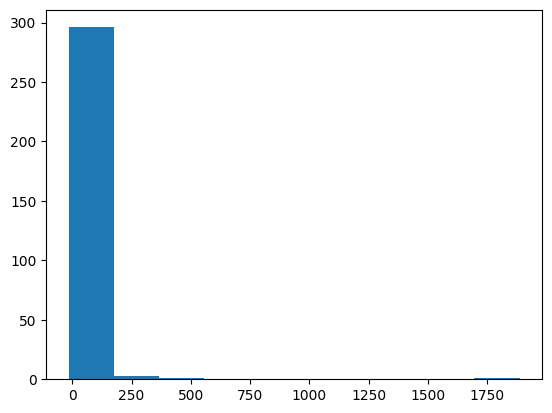

In [35]:
plt.hist(fraud_df['amount_change'])
plt.show()

In [36]:
final_df.groupby('is_fraud')['amount_change'].mean()

is_fraud
0     3.647126
1    16.664184
Name: amount_change, dtype: float64

In [37]:
final_df.groupby('is_fraud')['user_transaction_count'].mean()

is_fraud
0    26840.338249
1    21438.016611
Name: user_transaction_count, dtype: float64

Not to much different here

In [38]:
final_df.groupby('is_fraud')['total_amount'].mean()

is_fraud
0    1.294762e+06
1    1.043448e+06
Name: total_amount, dtype: float64

In [39]:
final_df.groupby('is_fraud')['average_amount'].mean()

is_fraud
0    53.274327
1    55.385154
Name: average_amount, dtype: float64

Will include percent change, will not include user transaction coutn, total amoutn, average amount

In [40]:
final_df.columns

Index(['user', 'year', 'month', 'day_of_week', 'is_weekend', 'hour_of_day',
       'amount', 'amount_bin', 'use_chip', 'merchant_name', 'merchant_city',
       'merchant_state', 'zip', 'mcc', 'card_type', 'has_chip', 'errors',
       'same_state_flag', 'us_state', 'user_transaction_count',
       'merchant_count', 'total_amount', 'average_amount',
       'days_since_last_transaction', 'amount_change', 'is_fraud'],
      dtype='object')

In [41]:
final_columns = ['user', 'year', 'month', 'day_of_week', 'is_weekend', 'hour_of_day', 'amount', 'amount_bin', 'use_chip', 
 'merchant_name', 'merchant_city', 'merchant_state', 'zip', 'mcc','errors', 'same_state_flag','is_fraud']

In [42]:
final_df.head()

,user,year,month,day_of_week,is_weekend,hour_of_day,amount,amount_bin,use_chip,merchant_name,...,errors,same_state_flag,us_state,user_transaction_count,merchant_count,total_amount,average_amount,days_since_last_transaction,amount_change,is_fraud
0,0,2002,9,6,0,6,134.09,3,Swipe Transaction,3527213246127876953,...,No Errors,1,1,19963,898,1622991.69,81.299989,6389,0.000000,0
1,0,2002,9,6,0,6,38.48,1,Swipe Transaction,-727612092139916043,...,No Errors,1,1,19963,1999,1622991.69,81.299989,6389,-0.713029,0
2,0,2002,9,0,0,6,120.34,3,Swipe Transaction,-727612092139916043,...,No Errors,1,1,19963,1999,1622991.69,81.299989,6388,2.127339,0
3,0,2002,9,0,0,17,128.95,3,Swipe Transaction,3414527459579106770,...,No Errors,1,1,19963,183,1622991.69,81.299989,6388,0.071547,0
4,0,2002,9,1,0,6,104.71,3,Swipe Transaction,5817218446178736267,...,No Errors,1,1,19963,7231,1622991.69,81.299989,6387,-0.187980,0


In [43]:
label_encoders = {}
final_df = final_df[final_columns]
final_df = pd.get_dummies(final_df,columns=['use_chip'], dtype=int)

encode_columns = ['merchant_city','merchant_state','zip','mcc','errors']

for col in encode_columns:
    label_encoders[col] = LabelEncoder()
    final_df[col + '_encoded'] = label_encoders[col].fit_transform(final_df[col])

final_df = final_df.drop(columns=encode_columns,axis=1)

In [44]:
final_df.head()

,user,year,month,day_of_week,is_weekend,hour_of_day,amount,amount_bin,merchant_name,same_state_flag,is_fraud,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,merchant_city_encoded,merchant_state_encoded,zip_encoded,mcc_encoded,errors_encoded
0,0,2002,9,6,0,6,134.09,3,3527213246127876953,1,0,0,0,1,1117,6,3308,53,16
1,0,2002,9,6,0,6,38.48,1,-727612092139916043,1,0,0,0,1,1379,6,3310,56,16
2,0,2002,9,0,0,6,120.34,3,-727612092139916043,1,0,0,0,1,1379,6,3310,56,16
3,0,2002,9,0,0,17,128.95,3,3414527459579106770,1,0,0,0,1,1379,6,3310,61,16
4,0,2002,9,1,0,6,104.71,3,5817218446178736267,1,0,0,0,1,1117,6,3308,74,16


In [45]:
X = final_df[[col for col in final_df.columns if col != 'is_fraud']]
y = final_df['is_fraud']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [48]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59045
           1       1.00      0.35      0.52        69

    accuracy                           1.00     59114
   macro avg       1.00      0.67      0.76     59114
weighted avg       1.00      1.00      1.00     59114

[[59045     0]
 [   45    24]]


In [49]:
# 8. Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

feature_importance.head(10)

,feature,importance
16,mcc_encoded,0.159428
8,merchant_name,0.124190
6,amount,0.119997
13,merchant_city_encoded,0.099580
1,year,0.088574
0,user,0.079346
5,hour_of_day,0.066899
14,merchant_state_encoded,0.062355
2,month,0.054898
15,zip_encoded,0.040843


In [53]:
final_cols = feature_importance['feature'].head(10).to_list()
print(final_cols)

['mcc_encoded', 'merchant_name', 'amount', 'merchant_city_encoded', 'year', 'user', 'hour_of_day', 'merchant_state_encoded', 'month', 'zip_encoded']


In [54]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

In [55]:
grid_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=grid_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=10, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=10)

In [56]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'max_depth': 30, 'n_estimators': 300}
Best cross-validation score: 1.00


In [57]:
best_model = grid_search.best_estimator_

In [58]:
# Make predictions using the best model
y_pred = best_model.predict(X_test_scaled)

In [59]:
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59045
           1       1.00      0.36      0.53        69

    accuracy                           1.00     59114
   macro avg       1.00      0.68      0.77     59114
weighted avg       1.00      1.00      1.00     59114

[[59045     0]
 [   44    25]]


In [60]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

feature_importance.head(10)

,feature,importance
16,mcc_encoded,0.162654
8,merchant_name,0.124400
6,amount,0.119237
13,merchant_city_encoded,0.097010
1,year,0.088567
0,user,0.081882
5,hour_of_day,0.066043
14,merchant_state_encoded,0.062421
2,month,0.055238
15,zip_encoded,0.040962
